# Bidirectional Quadratic Voting

## Experiments

### Simulator

In [51]:
import numpy as np
from scipy import stats

def generate_candidate_preferences(num_candidates, num_issues, ideology_range):
    candidate_preferences = np.zeros((num_candidates, num_issues))
    for i, ideology in enumerate(ideology_range):
        # 環境保護: 左派が高く、右派が低い傾向
        candidate_preferences[i, 0] = np.clip(5 - ideology * 2 + np.random.normal(0, 0.3), 0, 5)

        # 経済成長: 右派が高く、左派が低い傾向
        candidate_preferences[i, 1] = np.clip(2.5 + ideology * 2 + np.random.normal(0, 0.3), 0, 5)

        # 教育改革: イデオロギーによる偏りが少ない
        candidate_preferences[i, 2] = np.clip(3 + ideology * 0.5 + np.random.normal(0, 0.5), 0, 5)

        # 社会保障: 左派が高く、右派が低い傾向
        candidate_preferences[i, 3] = np.clip(4 - ideology * 1.5 + np.random.normal(0, 0.3), 0, 5)

        # 外交政策: 右派がやや高い傾向
        candidate_preferences[i, 4] = np.clip(3 + ideology + np.random.normal(0, 0.3), 0, 5)

        # テクノロジー: イデオロギーによる偏りが少ない
        candidate_preferences[i, 5] = np.clip(3 + ideology * 0.3 + np.random.normal(0, 0.5), 0, 5)

    # 特定の候補者に特徴的な政策を設定
    candidate_preferences[1, 5] = np.random.uniform(4.5, 5.0)  # 2番目の候補者はテクノロジーに強い

    return candidate_preferences

def generate_voter_preferences(num_voters, num_issues, ideology_distribution):
    # イデオロギー分布の生成
    if ideology_distribution == 'normal':
        voter_ideologies = np.random.normal(0, 0.5, num_voters)
    elif ideology_distribution == 'bimodal':
        voter_ideologies = np.concatenate([np.random.normal(-0.5, 0.3, num_voters//2), np.random.normal(0.5, 0.3, num_voters//2)])
    elif ideology_distribution == 'skewed_left':
        voter_ideologies = np.random.beta(2, 5, num_voters) * 2 - 1
    elif ideology_distribution == 'skewed_right':
        voter_ideologies = np.random.beta(5, 2, num_voters) * 2 - 1
    else:
        raise ValueError("無効なイデオロギー分布が指定されました")

    voter_preferences = np.zeros((num_voters, num_issues))
    for i, ideology in enumerate(voter_ideologies):
        # 基本的な選好を生成
        base_preferences = np.array([
            5 - ideology * 2,  # 環境保護
            2.5 + ideology * 2,  # 経済成長
            3 + ideology * 0.5,  # 教育改革
            4 - ideology * 1.5,  # 社会保障
            3 + ideology,  # 外交政策
            3 + ideology * 0.3  # テクノロジー
        ])

        # 個人差を追加
        personal_variation = np.random.normal(0, 0.5, num_issues)

        # 社会的影響を模倣（近いイデオロギーの人々からの影響）
        social_influence = np.mean([np.random.normal(0, 0.3, num_issues) for _ in range(5)], axis=0)

        # 最終的な選好を計算
        voter_preferences[i] = np.clip(base_preferences + personal_variation + social_influence, 0, 5)

    # 特定の問題に強い関心を持つ有権者グループを作成
    tech_voters = np.random.choice(num_voters, num_voters // 20, replace=False)
    voter_preferences[tech_voters, 5] = np.random.uniform(4.0, 5.0, len(tech_voters))

    return voter_preferences, voter_ideologies

def simulate_campaign_effect(voter_preferences, candidate_preferences, campaign_strength=0.1):
    num_voters, num_issues = voter_preferences.shape
    num_candidates = len(candidate_preferences)

    for i in range(num_candidates):
        # 各候補者のキャンペーン効果
        campaign_effect = (candidate_preferences[i] - voter_preferences) * campaign_strength

        # ランダムに選ばれた有権者に影響を与える
        affected_voters = np.random.choice(num_voters, num_voters // 5, replace=False)
        voter_preferences[affected_voters] += campaign_effect[affected_voters]

    return np.clip(voter_preferences, 0, 5)

def strategic_voting(voter_preferences, candidate_preferences, strategic_ratio=0.2):
    num_voters, num_issues = voter_preferences.shape
    num_candidates = len(candidate_preferences)

    strategic_voters = np.random.choice(num_voters, int(num_voters * strategic_ratio), replace=False)

    for voter in strategic_voters:
        # 上位2候補を特定
        scores = [np.dot(voter_preferences[voter], candidate_preferences[i]) for i in range(num_candidates)]
        top_two = np.argsort(scores)[-2:]

        # 2位の候補に投票を変更
        voter_preferences[voter] = candidate_preferences[top_two[1]]

    return voter_preferences

def quadratic_voting(preferences, credits):
    normalized_prefs = (preferences - np.min(preferences)) / (np.max(preferences) - np.min(preferences))
    votes = np.sign(normalized_prefs) * np.sqrt(np.abs(normalized_prefs))
    scale_factor = np.sqrt(credits / np.sum(votes**2))
    return votes * scale_factor

def calculate_normal_voting_matching_scores(distribution):
    return np.array(distribution)  # 実際の投票結果を直接返す

def calculate_quadratic_voting_matching_scores(voter_preferences, candidate_preferences):
    matching_scores = np.zeros(len(candidate_preferences))
    for voter in voter_preferences:
        voter_votes = quadratic_voting(voter, 100)
        candidate_scores = [np.dot(voter_votes, candidate) for candidate in candidate_preferences]
        normalized_scores = (candidate_scores - np.min(candidate_scores)) / (np.max(candidate_scores) - np.min(candidate_scores))
        matching_scores += normalized_scores
    return matching_scores / np.sum(matching_scores)

def calculate_bidirectional_quadratic_voting_matching_scores(voter_preferences, candidate_preferences):
    matching_scores = np.zeros(len(candidate_preferences))
    for voter in voter_preferences:
        voter_votes = quadratic_voting(voter, 100)
        candidate_votes = [quadratic_voting(candidate, 100) for candidate in candidate_preferences]
        candidate_scores = [np.dot(voter_votes, c_votes) for c_votes in candidate_votes]
        normalized_scores = (candidate_scores - np.min(candidate_scores)) / (np.max(candidate_scores) - np.min(candidate_scores))
        matching_scores += normalized_scores
    return matching_scores / np.sum(matching_scores)

### Prerequisites

In [52]:
import numpy as np

np.random.seed(42)

# Setting up issues
issues = ['Environmental Protection', 'Economic Growth', 'Education Reform', 'Social Security', 'Foreign Policy', 'Technology']
num_issues = len(issues)

# Setting up candidates
num_candidates = 5
candidates = [f'Candidate{i+1}' for i in range(num_candidates)]

# Setting up number of voters
num_voters = 10000

# Setting up ideology axis (-1: Far Left, 0: Center, 1: Far Right)
ideology_range = np.linspace(-1, 1, num_candidates)

# Generate candidate preferences (fixed)
candidate_preferences = generate_candidate_preferences(num_candidates, num_issues, ideology_range)

# Voter distribution patterns
voter_distributions = ['normal', 'bimodal', 'skewed_left', 'skewed_right']

# Tokyo Governor Election 2024 Results (Voting on July 7)
# https://www.nhk.or.jp/senkyo/database/local/shutoken/20336/skh54664.html
distribution = [0.188, 0.023, 0.243, 0.428, 0.039]

### Simulation

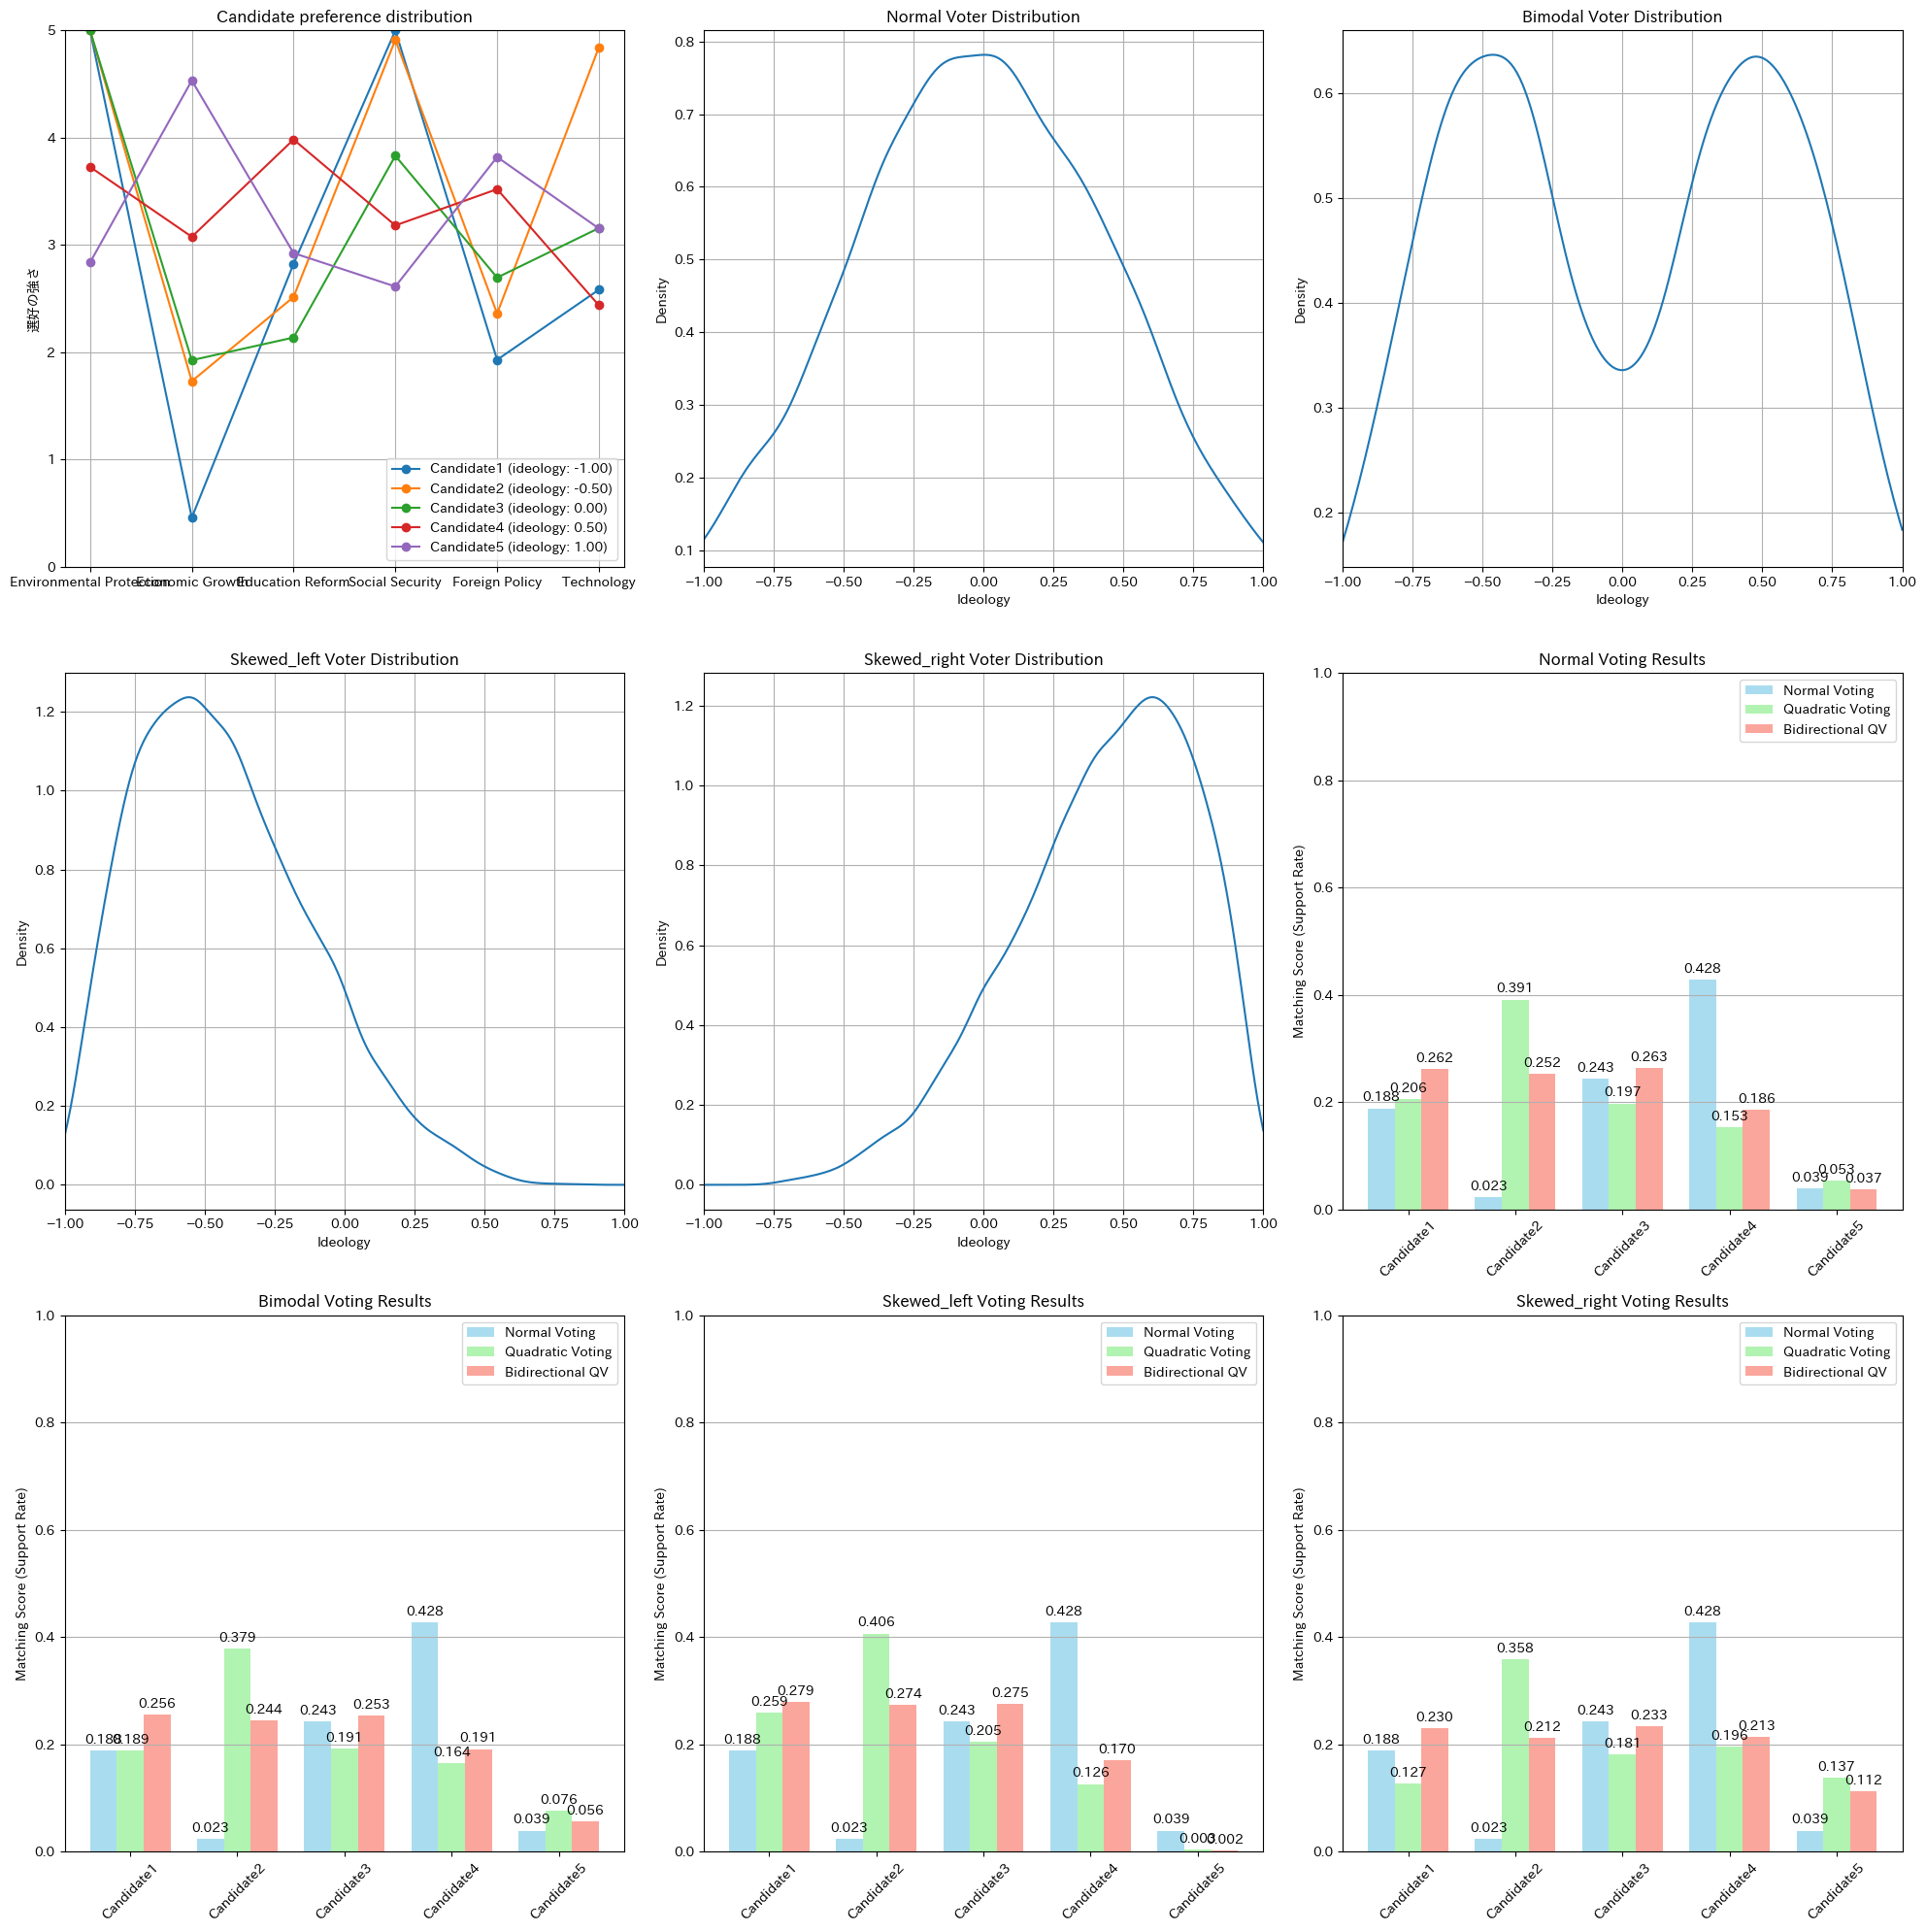

Candidate preferences:
Candidate1 (Ideology: -1.00): [5.         0.45852071 2.82384427 5.         1.92975399 2.58293152]
Candidate2 (Ideology: -0.50): [5.         1.73023042 2.51526281 4.91276801 2.36097469 4.84211651]
Candidate3 (Ideology: 0.00): [5.         1.92601593 2.13754108 3.83131374 2.69615066 3.15712367]
Candidate4 (Ideology: 0.50): [3.72759278 3.07630889 3.98282438 3.18226711 3.52025846 2.43762591]
Candidate5 (Ideology: 1.00): [2.83668518 4.53327678 2.92450321 2.61270941 3.81980839 3.15415313]

Normal Voter Distribution:
Matching scores by normal voting:
  Candidate1: 0.188
  Candidate2: 0.023
  Candidate3: 0.243
  Candidate4: 0.428
  Candidate5: 0.039
Matching scores by Quadratic Voting:
  Candidate1: 0.206
  Candidate2: 0.391
  Candidate3: 0.197
  Candidate4: 0.153
  Candidate5: 0.053
Matching scores by Bidirectional Quadratic Voting:
  Candidate1: 0.262
  Candidate2: 0.252
  Candidate3: 0.263
  Candidate4: 0.186
  Candidate5: 0.037

Bimodal Voter Distribution:
Matching sc

In [53]:
import japanize_matplotlib
import matplotlib.pyplot as plt

results = {}
for v_dist in voter_distributions:
    voter_preferences, voter_ideologies = generate_voter_preferences(num_voters, num_issues, v_dist)

    # 選挙キャンペーンの影響をシミュレート
    voter_preferences = simulate_campaign_effect(voter_preferences, candidate_preferences)

    # 戦略的投票行動をシミュレート
    voter_preferences = strategic_voting(voter_preferences, candidate_preferences)

    normal_scores = calculate_normal_voting_matching_scores(distribution)
    quadratic_scores = calculate_quadratic_voting_matching_scores(voter_preferences, candidate_preferences)
    bidirectional_scores = calculate_bidirectional_quadratic_voting_matching_scores(voter_preferences, candidate_preferences)
    results[v_dist] = (voter_ideologies, normal_scores, quadratic_scores, bidirectional_scores)

# Visualization of results
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# Candidate preference distribution
axes[0, 0].set_title('Candidate preference distribution')
for i, prefs in enumerate(candidate_preferences):
    axes[0, 0].plot(issues, prefs, marker='o', label=f'{candidates[i]} (ideology: {ideology_range[i]:.2f})')
axes[0, 0].set_ylabel('選好の強さ')
axes[0, 0].set_ylim(0, 5)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Voter ideology distribution and comparison of voting methods
voter_dist_positions = [(0, 1), (0, 2), (1, 0), (1, 1)]
voting_result_positions = [(1, 2), (2, 0), (2, 1), (2, 2)]

for i, (v_dist, (voter_ideologies, normal_scores, quadratic_scores, bidirectional_scores)) in enumerate(results.items()):
    # Voter ideology distribution
    row, col = voter_dist_positions[i]
    ax_hist = axes[row, col]
    kde = stats.gaussian_kde(voter_ideologies)
    x_range = np.linspace(-1, 1, 200)
    ax_hist.plot(x_range, kde(x_range))
    ax_hist.set_title(f'{v_dist.capitalize()} Voter Distribution')
    ax_hist.set_xlabel('Ideology')
    ax_hist.set_ylabel('Density')
    ax_hist.set_xlim(-1, 1)
    ax_hist.grid(True)

    # Comparison of voting methods
    row, col = voting_result_positions[i]
    ax_match = axes[row, col]
    x = np.arange(len(candidates))
    width = 0.25

    rects1 = ax_match.bar(x - width, normal_scores, width, label='Normal Voting', color='skyblue', alpha=0.7)
    rects2 = ax_match.bar(x, quadratic_scores, width, label='Quadratic Voting', color='lightgreen', alpha=0.7)
    rects3 = ax_match.bar(x + width, bidirectional_scores, width, label='Bidirectional QV', color='salmon', alpha=0.7)

    ax_match.set_ylabel('Matching Score (Support Rate)')
    ax_match.set_title(f'{v_dist.capitalize()} Voting Results')
    ax_match.set_xticks(x)
    ax_match.set_xticklabels(candidates, rotation=45)
    ax_match.set_ylim(0, 1)
    ax_match.legend()
    ax_match.grid(axis='y')

    # Display numerical values on bar graphs
    def autolabel(rects, scores):
        for rect, score in zip(rects, scores):
            height = rect.get_height()
            ax_match.annotate(f'{score:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1, normal_scores)
    autolabel(rects2, quadratic_scores)
    autolabel(rects3, bidirectional_scores)

plt.tight_layout()
plt.show()

# Output of results
print("Candidate preferences:")
for i, prefs in enumerate(candidate_preferences):
    print(f"{candidates[i]} (Ideology: {ideology_range[i]:.2f}): {prefs}")

for v_dist, (_, normal_scores, quadratic_scores, bidirectional_scores) in results.items():
    print(f"\n{v_dist.capitalize()} Voter Distribution:")
    print("Matching scores by normal voting:")
    for i, score in enumerate(normal_scores):
        print(f"  {candidates[i]}: {score:.3f}")
    print("Matching scores by Quadratic Voting:")
    for i, score in enumerate(quadratic_scores):
        print(f"  {candidates[i]}: {score:.3f}")
    print("Matching scores by Bidirectional Quadratic Voting:")
    for i, score in enumerate(bidirectional_scores):
        print(f"  {candidates[i]}: {score:.3f}")